In [1]:
import numpy as np
import matplotlib.pyplot as plt
import visualization
import os
from gta_math import points_to_homo, ndc_to_view, construct_proj_matrix, view_to_world, construct_view_matrix
from visualization import load_depth, load_stencil, save_pointcloud_csv, bbox_from_string
import progressbar
from joblib import Parallel, delayed
from configparser import ConfigParser
from PIL import Image
import pickle
import json
from datetime import timedelta, datetime, date
from matplotlib.dates import DateFormatter, DateFormatter, HourLocator
import csv
from voxelmaps import camera_to_pointcloud, load_scene_db_data, get_main_image_name, scene_to_pointcloud, \
scene_to_voxelmap, NoMainImageException, scene_to_voxelmap_with_map, get_main_image, ndc_pcl_to_grid_linear_view, \
generate_frustum_points, pointclouds_to_voxelmap_with_map, to_main_cam_view
import voxelmaps
import gta_math

In [2]:
ini_file = "gta-postprocessing.ini"
visualization.multi_page = False
visualization.ini_file = ini_file

conn = visualization.get_connection()
cur = conn.cursor()

CONFIG = ConfigParser()
CONFIG.read(ini_file)
tiff_directory = CONFIG["Images"]["Tiff"]
jpeg_directory = r'D:\\'
test_files_csv = r'D:\test-voxel-gta.csv'
out_directory = r'D:\data-pipeline-demonstration'

In [3]:
rgb_files = []
with open(test_files_csv) as f:
    reader = csv.reader(f)
    for line in reader:
        rgb_files.append(line[0])

ml-datasets-voxel/2018-03-07--15-18-41--088.jpg


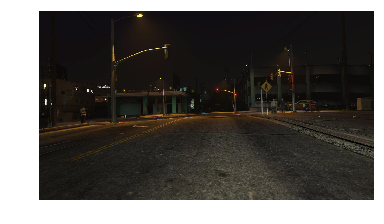

ml-datasets-voxel/2018-03-07--15-28-22--394.jpg


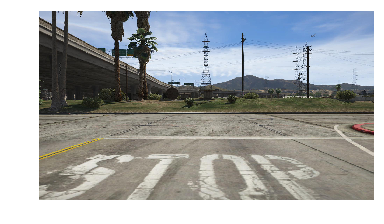

ml-datasets-voxel/2018-03-07--16-15-01--424.jpg


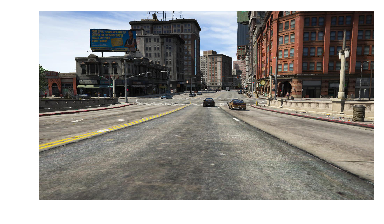

ml-datasets-voxel/2018-03-07--16-02-39--065.jpg


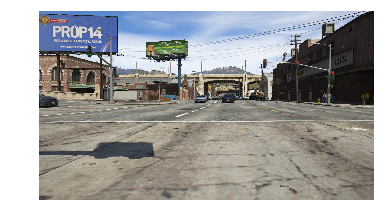

ml-datasets-voxel/2018-03-07--16-35-01--415.jpg


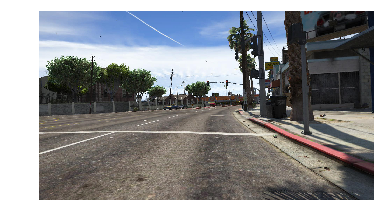

ml-datasets-voxel/2018-03-07--15-29-01--274.jpg


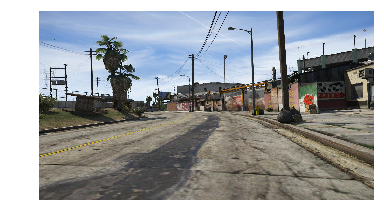

ml-datasets-voxel/2018-03-07--16-58-03--794.jpg


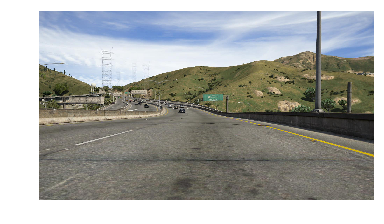

ml-datasets-voxel/2018-03-07--16-02-30--834.jpg


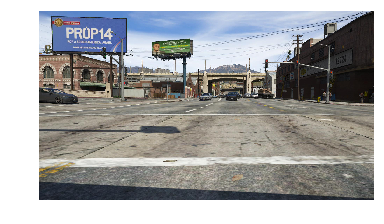

ml-datasets-voxel/2018-03-07--15-19-06--337.jpg


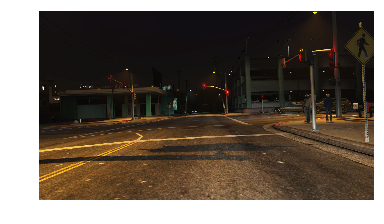

ml-datasets-voxel/2018-03-07--17-20-15--311.jpg


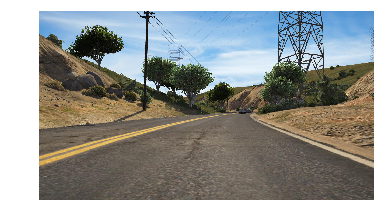

ml-datasets-voxel/2018-03-07--15-51-53--110.jpg


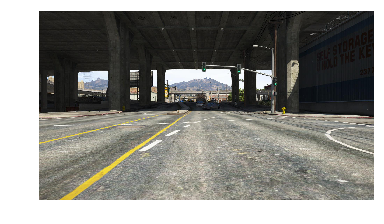

ml-datasets-voxel/2018-03-07--18-42-19--411.jpg


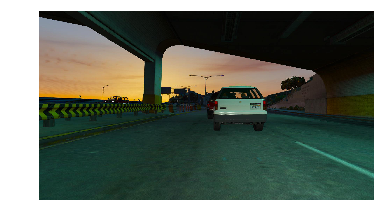

ml-datasets-voxel/2018-03-07--16-31-31--415.jpg


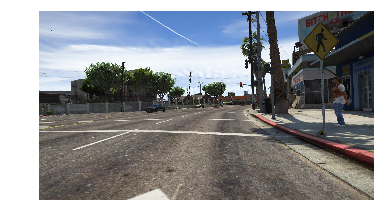

ml-datasets-voxel/2018-03-07--17-01-24--818.jpg


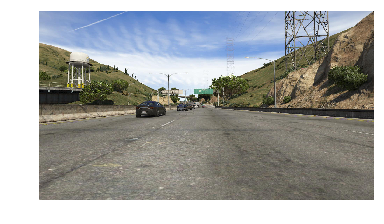

ml-datasets-voxel/2018-03-07--16-40-44--634.jpg


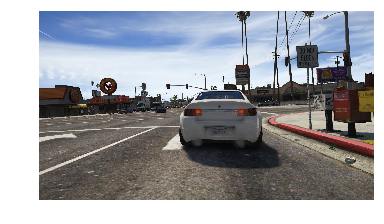

ml-datasets-voxel/2018-03-07--15-49-43--288.jpg


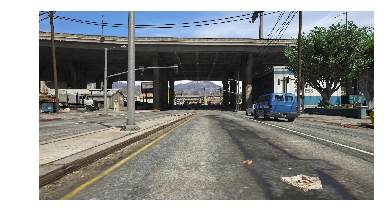

ml-datasets-voxel/2018-03-07--17-27-54--059.jpg


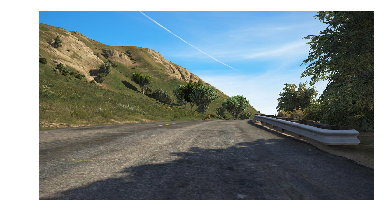

ml-datasets-voxel/2018-03-07--16-55-14--408.jpg


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [4]:
for name in rgb_files[20:40]:
    print(name)
    plt.figure()
    plt.imshow(Image.open(os.path.join(jpeg_directory, name)).convert('RGB'))
    plt.axis('off')
    plt.show()

## now showing whole process for one image

In [5]:
#main_name = '2018-03-07--16-40-42--901'
#main_name = '2018-03-07--15-44-56--353'
#main_name = '2018-03-07--17-41-16--827'
main_name = '2018-05-08--14-15-35--576'

cur.execute("""SELECT scene_id \
    FROM snapshots \
    WHERE imagepath = '{}' \
    """.format(main_name))

scene_id = list(cur)[0]['scene_id']
print(scene_id)

cameras = load_scene_db_data(scene_id)

5b63440c-e668-4d19-b349-45c12cada7e4


2018-05-08--14-15-35--576


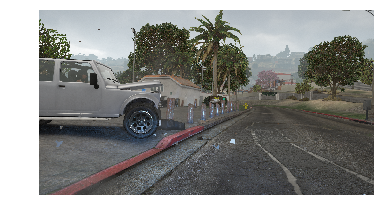

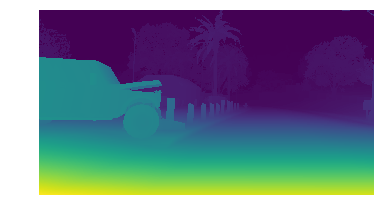

2018-05-08--14-15-35--972


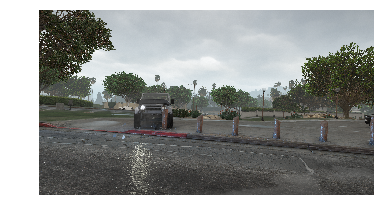

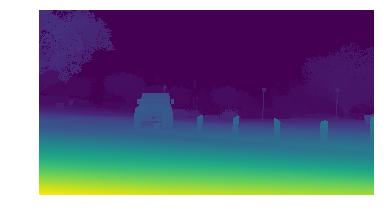

2018-05-08--14-15-36--349


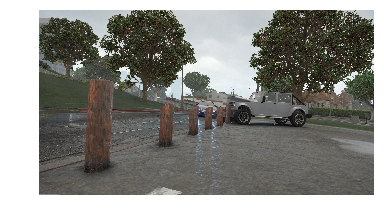

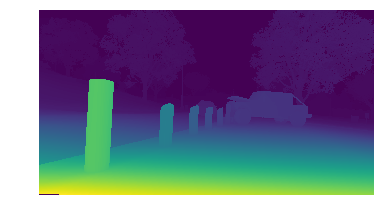

2018-05-08--14-15-36--728


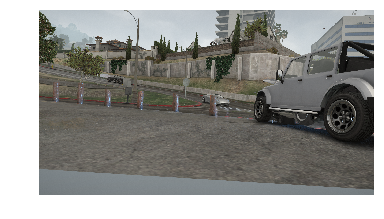

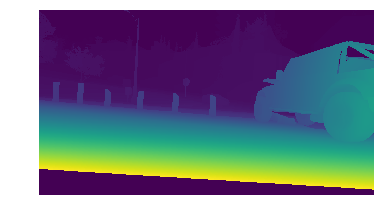

In [6]:
for cam in cameras:
    print(cam['imagepath'])
    im = Image.open(os.path.join(tiff_directory, cam['imagepath']+'.tiff'))
    im = im.convert(mode="RGB")
    im.save(os.path.join(out_directory, cam['imagepath']+'.jpg'))
    plt.figure()
    plt.imshow(im)
    plt.axis('off')
    plt.show()
    
    depth = load_depth(cam['imagepath'])
    depth = depth * np.iinfo(np.uint8).max
    im = Image.fromarray(depth.astype(np.uint8), mode="L")
    im.save(os.path.join(out_directory, cam['imagepath']+'-depth.png'))
    plt.figure()
    plt.imshow(depth)
    plt.axis('off')
    plt.show()
    

In [7]:
voxelmaps.MAX_DISTANCE = 30
gta_math.PROJECTING = True

pcls, cam_positions = scene_to_pointcloud(cameras)
pcls, cam_positions = to_main_cam_view(cameras, pcls, cam_positions)
sub_pcls, sub_cam_positions = scene_to_pointcloud(cameras, 0.12)
sub_pcls, sub_cam_positions = to_main_cam_view(cameras, sub_pcls, sub_cam_positions)

pcl = np.hstack(pcls)
sub_pcl = np.hstack(sub_pcls)
save_pointcloud_csv(pcl.T[:, 0:3], '{}/orig-poincloud-{}.csv'.format(out_directory, main_name))
save_pointcloud_csv(sub_pcl.T[:, 0:3], '{}/subsampled-poincloud-{}.csv'.format(out_directory, main_name))

print('orig sizes: ', [p.shape[1] for p in pcls])
print('sub sizes: ', [p.shape[1] for p in sub_pcls])


orig sizes:  [2029440, 2029440, 2029440, 2029440]
sub sizes:  [83944, 105528, 113463, 82255]


In [10]:
# showing original, not projected pointcloud for visualization of original 3D map
voxelmaps.MAX_DISTANCE = 1000
gta_math.PROJECTING = True

print([c['cam_far_clip'] for c in cameras])
big_pcls, cam_positions = scene_to_pointcloud(cameras)
print([c['cam_far_clip'] for c in cameras])
big_pcls, cam_positions = to_main_cam_view(cameras, big_pcls, cam_positions)
big_pcl = np.hstack(big_pcls)
save_pointcloud_csv(big_pcl.T[:, 0:3], '{}/big-orig-poincloud-{}.csv'.format(out_directory, main_name))


[1000, 1000, 1000, 1000]
[1000, 1000, 1000, 1000]


In [9]:
print(big_pcl.max(axis=1) - big_pcl.min(axis=1))
print(pcl.max(axis=1) - (pcl.min(axis=1)))
print([c['cam_far_clip'] for c in cameras])


[ 1468.88401646  1961.888309     297.20208627]
[ 52.3229654   33.65264202  52.34673819]
[1000, 1000, 1000, 1000]


In [28]:
voxels, values, map_voxel_size, map_obj = pointclouds_to_voxelmap_with_map(sub_pcls, sub_cam_positions)
save_pointcloud_csv(voxels.T[:, 0:3], '{}/voxelmap-all-{}.csv'.format(out_directory, main_name))


In [29]:
occupied_voxels_view = voxels[:, values > 0]
free_voxels_view = voxels[:, values < 0]
save_pointcloud_csv(occupied_voxels_view.T[:, 0:3], '{}/voxelmap-occupied-{}.csv'.format(out_directory, main_name))
save_pointcloud_csv(free_voxels_view.T[:, 0:3], '{}/voxelmap-free-{}.csv'.format(out_directory, main_name))


In [30]:
x_min = -1
x_max = 1
y_min = -1
y_max = 1
x_range = 160
y_range = 120
z_range = 100
z_meters_min = 1.5
z_meters_max = 25
linear_view_sampling = True

cam = get_main_image(cameras)
proj_matrix = cam['proj_matrix']

positions, z_max, z_min = generate_frustum_points(proj_matrix, x_range, y_range, z_range, z_meters_min, z_meters_max, linear_view_sampling)
points_view = ndc_to_view(positions, proj_matrix)
save_pointcloud_csv(points_view.T[:, 0:3], '{}/frustum-{}.csv'.format(out_directory, main_name))

voxel_values = map_obj.get_voxels(points_view[0:3, :], np.zeros((points_view.shape[1], 1)))
occupied_view_points = points_view[:, voxel_values > 0]
invalid_view_points = points_view[:, np.isnan(voxel_values)]
save_pointcloud_csv(occupied_view_points.T[:, 0:3], '{}/occupied-voxel-{}.csv'.format(out_directory, main_name))
save_pointcloud_csv(invalid_view_points.T[:, 0:3], '{}/invalid-voxel-{}.csv'.format(out_directory, main_name))


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater


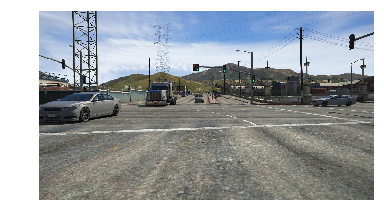

In [15]:
plt.figure()
plt.imshow(Image.open(os.path.join(jpeg_directory, 'ml-datasets-voxel/2018-03-07--15-44-56--353.jpg')).convert('RGB'))
plt.axis('off')
plt.show()